<a href="https://colab.research.google.com/github/jlcaballero999/MC_Bootstrap_GEE/blob/main/Copia_de_Monte_Carlo_%26_Bootstrap_GEE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importación de bibliotecas necesarias

In [ ]:
import ee
import geemap
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
ee.Authenticate()
ee.Initialize(project='ee-alequech')

In [ ]:
n_simulations = 100 # Número de simulaciones (muestras bootstrap) que se realizarán
training = ee.FeatureCollection('projects/ee-biomasa2/assets/Donw_Scaling/TrainingMU') ##  MU = AGBD
PotFusionFA = ee.Image("projects/ee-biomasa2/assets/LangFA_gee_Clean_v3") \
                .rename("LangFA_gee")
stacked = (
    ee.Image("projects/ee-fireforest2/assets/Landsat_30m_Amaz")
      .select(['VH_mean', 'VV_mean', 'elevation'])
      .addBands(PotFusionFA)
)

## Feature collection to geopandas
training_df = ee.data.computeFeatures({
    'expression': training,
    'fileFormat': 'GEOPANDAS_GEODATAFRAME'
})

training_df['Index'] = range(1, len(training_df) + 1)
training_df =  training_df.set_crs('epsg:4326')

print( training_df.columns)
#training_df.head()

Index(['geometry', 'Index', 'LangFA_gee', 'MU', 'PE', 'QF', 'SAA', 'SADA',
       'SB', 'SE', 'VH_mean', 'VV_mean', 'ZH', 'aspect', 'class', 'elevation',
       'index', 'latitude', 'longitude', 'random1', 'slope', 'system_ind',
       'unique_id'],
      dtype='object')


In [ ]:
training_df_filtered = training_df[["Index","MU","LangFA_gee","VH_mean",'VV_mean',"elevation", "geometry"]]
training_df_filtered.head()

,Index,MU,LangFA_gee,VH_mean,VV_mean,elevation,geometry
0,1,188.439400,33.644123,-12.860593,-6.127866,217.0180,POINT (-75.29564 -7.93702)
1,2,103.154280,31.040205,-12.347179,-5.835666,443.2379,POINT (-72.71266 -11.79048)
2,3,167.686890,33.562320,-12.490586,-5.787099,211.4272,POINT (-75.1193 -1.50261)
3,4,126.093124,29.176380,-12.213165,-5.582523,124.8904,POINT (-73.52178 -2.74307)
4,5,205.734160,33.184530,-12.467673,-5.939185,132.2515,POINT (-72.59855 -4.93693)


# Función para generar muestras Bootstrap
Genera muestras bootstrap a partir de un DataFrame.
Parámetros:

 - df : pandas.DataFrame o geopandas.GeoDataFrame
   El DataFrame de entrada del cual se generarán las muestras.
  
 - n_boot : int, opcional
   Número de muestras bootstrap a crear. Por defecto, se crean 10.
  
- Retorna: list
  Lista de DataFrames, donde cada elemento representa una muestra bootstrap.
   


In [ ]:
def create_bootstrap_samples(df, n_boot=10):
    samples = []
    original_size = len(df)
    for i in range(n_boot):
        sample_df = df.sample(n=original_size, replace=True, random_state=np.random.randint(0, 1e9))
        samples.append(sample_df)
    return samples

bootstrap_samples = create_bootstrap_samples(training_df_filtered, n_simulations)

# Imprimir la primera muestra bootstrap para verificación
Muestra las primeras filas de la primera muestra

In [ ]:
print("First bootstrap sample:")
print(bootstrap_samples[0].head())

First bootstrap sample:
      Index         MU  LangFA_gee    VH_mean   VV_mean  elevation  \
1945   1946  218.82956    33.67578 -12.666686 -6.233367   144.0975   
408     409  236.85416    31.97430 -12.436385 -5.609520   155.6494   
674     675  186.68353    23.99470 -12.739250 -5.368217   148.8372   
1010   1011  232.13982    31.01510 -13.271187 -6.518700  1074.7388   
720     721  126.08967    24.72220 -12.506935 -5.502080   191.7390   

                         geometry  
1945    POINT (-72.90975 -5.2756)  
408     POINT (-75.8973 -4.29155)  
674    POINT (-76.72718 -4.99205)  
1010  POINT (-74.24793 -11.71039)  
720    POINT (-76.27075 -3.47377)  


# Imprimir la segunda muestra bootstrap para verificación
Muestra las primeras filas de la segunda muestra

In [ ]:
print("second bootstrap sample:")
print(bootstrap_samples[1].head())

second bootstrap sample:
      Index          MU  LangFA_gee    VH_mean   VV_mean  elevation  \
1246   1247  247.215880   33.953533 -12.554934 -6.034762   245.8845   
18       19  187.139560   31.384193 -12.301914 -5.855813   132.0794   
859     860  119.656370   12.659400 -14.790056 -6.892002   491.6544   
1844   1845  293.590900   33.702423 -12.722556 -5.970576   414.1561   
1080   1081    8.019056   14.738100 -14.629694 -8.110458    95.0725   

                         geometry  
1246   POINT (-75.62759 -2.99444)  
18     POINT (-72.16286 -2.90017)  
859     POINT (-76.4471 -8.31733)  
1844  POINT (-71.73755 -11.86259)  
1080   POINT (-73.81224 -4.61417)  


### Histograma de entrenamiento (AGBD)

n= 2210


<Axes: ylabel='Frequency'>

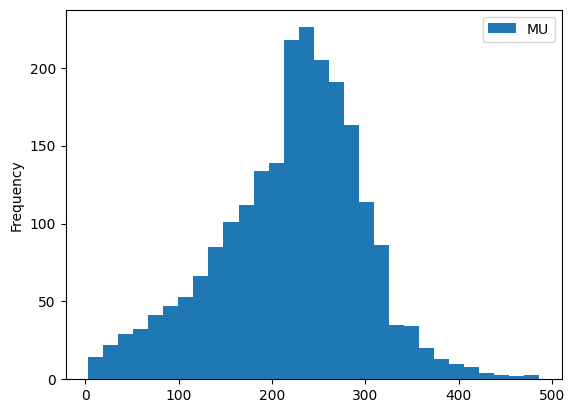

In [ ]:
print('n=',training.size().getInfo())
training_df_filtered.plot.hist(column ='MU', bins=30)


### Histograma del primer bootstrap (AGBD)

<Axes: ylabel='Frequency'>

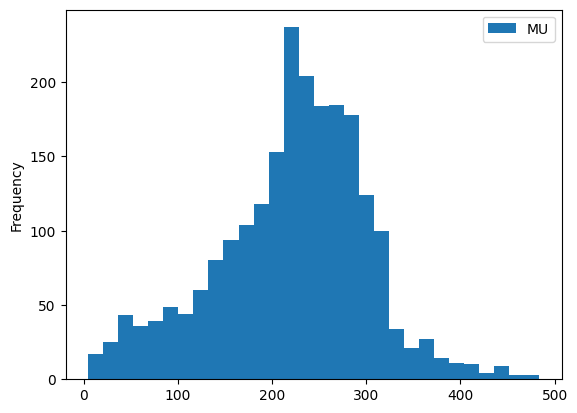

In [ ]:
bootstrap_samples[0].plot.hist(column ='MU', bins=30)

## Ejemplo de una simulación

In [ ]:
#type(bootstrap_samples)
training_boostrap =  geemap.geopandas_to_ee(bootstrap_samples[0])
predicted = 'MU'
predictors = ["MU","LangFA_gee","VH_mean",'VV_mean',"elevation"]

model = (ee.Classifier.smileRandomForest(numberOfTrees=200)
         .setOutputMode('REGRESSION')
         .train(
             features=training_boostrap,
             classProperty=predicted,
             inputProperties=predictors
         ))

prediction = stacked.classify(model)

## Simulación Monte Carlo

In [ ]:
def classify_one_bootstrap(df, iteration):

    training_ee = geemap.geopandas_to_ee(df)

    # Train a Random Forest regressor
    model = (ee.Classifier.smileRandomForest(numberOfTrees=200)
             .setOutputMode('REGRESSION')
             .train(
                features=training_ee,
                classProperty=predicted,
                inputProperties=predictors
             ))

    classified_img = stacked.classify(model).rename(f'MU_{iteration}')

    return classified_img

image_list = []
for i, df in enumerate(bootstrap_samples):
    classified_img = classify_one_bootstrap(df, i)
    image_list.append(classified_img)
    ##print("iteration:",i)


predictionCollection = ee.ImageCollection(image_list)

def standardize_band_names(image):
     return image.rename('MU')

standardizedCollection = predictionCollection.map(standardize_band_names)

meanPrediction = standardizedCollection.reduce(ee.Reducer.mean()).rename('MU_mean')
stdDevPrediction = standardizedCollection.reduce(ee.Reducer.stdDev()).rename('MU_stdDev')
variancePrediction = standardizedCollection.reduce(ee.Reducer.variance()).rename('MU_variance')

#print("Mean prediction info:", meanPrediction.getInfo())
#print("StdDev prediction info:", stdDevPrediction.getInfo())
#print("Variance prediction info:", variancePrediction.getInfo())

# Preparar exportartación
Combinar las métricas generadas (promedio, desviación estándar y varianza) en una sola imagen

In [ ]:
#export_image = meanPrediction.addBands([stdDevPrediction, variancePrediction])

#task = ee.batch.Export.image.toAsset(
#    image=export_image,
#    description='MonteCarlo_MU',
#    assetId='projects/ee-alequech/assets/consultorias/peru/MonteCarlo_MU_100s_v2',
#    region=stacked.geometry(),
#    crs='EPSG:4326',
#    scale=30,
#    maxPixels=1e12
#)
#task.start()

KeyboardInterrupt: 

# Verificar el estado de la tarea de exportación
Obtener el estado de la tarea utilizando su ID

In [ ]:
#status = ee.data.getTaskStatus(task.id)[0]
#print(status)